In [36]:
using DifferentialEquations, ParameterizedFunctions, Sundials, DataFrames, Plots, StatsPlots

In [23]:
function ribofinal(dydt, init, parameters, t)

    dm, kb, ku, Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx = parameters
    a, em, et, mm, mq, mr, mt, eq, er, rmm, rmq, rmr, rmt, si = init
    
    #define change arrays
    da, dem, det, dmm, dmq, dmr, dmt, deq, der, drmm, drmq, drmr, drmt, dsi = zeros(length(dydt))
    
    
    # import
    # s0 -> si; following a Michaelis-Menten dynamic: et*vt*s0/(Kt+s0)
    imp = (et*vt*s0/(Kt + s0))
    
    dsi = dsi + imp
    
    # metabolism
    # si -> a; following a Michaelis-Menten dynamic: em*vm*si/(Km + si)
    nucat= em*vm*si/(Km + si)
    
    da = da +nucat * ns
    dsi = dsi -nucat
        
    # transcription 
    # 0 -> rx; following a Michaelis-Menten dynamic: x*a/(theta+a)
    function transcriptionMM(wx,theta) wx*a/(theta+a) end
    
    dmm = dmm +transcriptionMM(we0,thetax)
    dmr = dmr +transcriptionMM(wr0,thetar)
    dmt = dmt +transcriptionMM(we0,thetax)
    
    # q-compartment inhibition
    # In the case of compartment q, included autoinhibition 1+(q/kq^nq)
    qMM = 1+(eq/kq)^nq

    dmq = dmq + transcriptionMM(wq0,thetax)/qMM   
    
    # translation
    
    ## binding
    # rx + r <-> rmx; at forward rate: kb*rx*r
    #                  at backward rate: ku*rmx

    function bind(mx) mx*er*kb end
    function unbind(rmx) rmx*ku end

    dmm = dmm + unbind(rmm) -bind(mm)
    dmq = dmq + unbind(rmq) -bind(mq)
    dmr = dmr + unbind(rmr) -bind(mr)
    dmt = dmt + unbind(rmt) -bind(mt)
    der = der + unbind(rmr+rmt+rmm+rmq) -bind(mr+mt+mm+mq)
    drmm = drmm -unbind(rmm) +bind(mm)
    drmq = drmq -unbind(rmq) +bind(mq)
    drmr = drmr -unbind(rmr) +bind(mr)
    drmt = drmt -unbind(rmt) +bind(mt)
      
    ## main part and release
    # rmx + nx * a ->  x + r; at forward rate: gmax*a/(Kg + a)
    
    Kg= gmax/Kp
    gamma= gmax*a/(Kg + a)

    function transRate(transRibo,protLen) transRibo*gamma/protLen end
    
    da = da -gamma*(rmq + rmr + rmt + rmm)
    dem = dem +  transRate(rmm,nx)
    deq = deq +  transRate(rmq,nx)
    der = der +2*transRate(rmr,nr) +transRate(rmt+rmm+rmq,nx)
    det = det +  transRate(rmt,nx)
    drmm = drmm -transRate(rmm,nx)
    drmq = drmq -transRate(rmq,nx)
    drmr = drmr -transRate(rmr,nr)
    drmt = drmt -transRate(rmt,nx)
    
    # degradation
    # mx -> 0; at a rate dm*mx
    function degrade(mx) dm*mx end
    dmm = dmm -degrade(mm)
    dmq = dmq -degrade(mq)
    dmr = dmr -degrade(mr)
    dmt = dmt -degrade(mt)
    
    # growth rate
    ttrate= (rmq + rmr + rmt + rmm)*gamma
    lam= ttrate/aatot

    #dilution
    # x -> 0; at a rate lam*x
    function dilute(x) lam*x end

    da = da -dilute(a)
    dem = dem -dilute(em)
    det = det -dilute(et)
    dmm = dmm -dilute(mm)
    dmq = dmq -dilute(mq)
    dmr = dmr -dilute(mr)
    dmt = dmt -dilute(mt)
    deq = deq -dilute(eq)
    der = der -dilute(er)
    drmm = drmm -dilute(rmm)
    drmq = drmq -dilute(rmq)
    drmr = drmr -dilute(rmr)
    drmt = drmt -dilute(rmt)
    dsi = dsi -dilute(si)
    
    dydt[1] = da
    dydt[2] = dem
    dydt[3] = det
    dydt[4] = dmm
    dydt[5] = dmq
    dydt[6] = dmr
    dydt[7] = dmt
    dydt[8] = deq
    dydt[9] = der
    dydt[10] = drmm
    dydt[11] = drmq
    dydt[12] = drmr
    dydt[13] = drmt
    dydt[14] = dsi

end 


ribofinal (generic function with 1 method)

In [24]:
# parameters

# define rate constants
dm= 0.1
kb= 1
ku= 1.0

Kp= 7.0
thetar= 426.87
kq= 152219
thetax= 4.38
wr0= 93
wq0= 949
we0= 4.38
gmax= 1260.0
aatot= 1.0e8
vt= 726.0
Kt= 1.0e3
s0= 1.0e4
vm= 5800.0
Km= 1.0e3
ns= 0.5
nq= 4
nr= 7549.0
nx= 300.0

parameters= [dm, kb, ku, Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx]

# define initial conditions
a_0= 1000.0
em_0= 10
et_0= 10
mm_0= 10
mq_0= 10
mr_0= 10
mt_0= 10
eq_0= 10
er_0= 10.0
rmm_0= 0
rmt_0= 0
rmq_0= 0
rmr_0= 0
si_0= 0

init= [a_0, em_0, et_0, mm_0, mq_0, mr_0, mt_0, eq_0, er_0, rmm_0, rmt_0, rmq_0, rmr_0, si_0]
species = [:a, :em, :et, :mm, :mq, :mr, :mt, :eq, :er, :rmm, :rmq, :rmr, :rmt, :si]


tspan = (0.,10000.)
prob = ODEProblem(ribofinal,init,tspan,parameters)

sol = solve(prob, CVODE_BDF());


solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)



441×14 DataFrame. Omitted printing of 8 columns
│ Row │ a       │ em      │ et      │ mm          │ mq       │ mr        │
│     │ Float64 │ Float64 │ Float64 │ Float64     │ Float64  │ Float64   │
├─────┼─────────┼─────────┼─────────┼─────────────┼──────────┼───────────┤
│ 1   │ 1000.0  │ 10.0    │ 10.0    │ 10.0        │ 10.0     │ 10.0      │
│ 2   │ 1000.0  │ 10.0    │ 10.0    │ 10.0        │ 10.0     │ 10.0      │
│ 3   │ 1000.0  │ 10.0    │ 10.0    │ 9.99983     │ 10.0015  │ 9.99994   │
│ 4   │ 1000.0  │ 10.0    │ 10.0    │ 9.9981      │ 10.0166  │ 9.9993    │
│ 5   │ 1000.0  │ 10.0    │ 10.0    │ 9.99638     │ 10.0317  │ 9.99866   │
│ 6   │ 1000.0  │ 10.0    │ 10.0    │ 9.99279     │ 10.0631  │ 9.99734   │
│ 7   │ 999.999 │ 10.0    │ 10.0    │ 9.985       │ 10.1315  │ 9.99447   │
│ 8   │ 999.997 │ 10.0    │ 10.0    │ 9.96658     │ 10.2942  │ 9.98777   │
│ 9   │ 999.978 │ 10.0001 │ 10.0001 │ 9.91258     │ 10.7802  │ 9.96869   │
│ 10  │ 999.94  │ 10.0004 │ 10.0004 │ 9.8602      │ 11.2649  │ 9.95103   │
⋮
│ 431 │ 424.191 │ 809.727 │ 809.727 │ 0.00075576  │ 0.114784 │ 0.055301  │
│ 432 │ 424.191 │ 809.727 │ 809.727 │ 0.000753528 │ 0.11448  │ 0.055141  │
│ 433 │ 424.191 │ 809.727 │ 809.727 │ 0.000755843 │ 0.114795 │ 0.0553069 │
│ 434 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.11462  │ 0.0552143 │
│ 435 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 436 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 437 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 438 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 439 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 440 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │
│ 441 │ 424.191 │ 809.727 │ 809.727 │ 0.000754552 │ 0.114619 │ 0.0552143 │

In [25]:
function calculateLambda(finalState, parameters)
    Kg= gmax/Kp
    a = finalState[:a]
    gamma= gmax*a/(Kg + a)
    ttrate= sum(finalState[[:rmq, :rmr, :rmt, :rmm]])*gamma
    
    return(ttrate/aatot)
    
end

function calculateDivRate(finalState,parameters)
    lam = calculateLambda(finalState,parameters)
    
    return(log(2)/lam)
end

function calculateTotalRNA(finalState, parameters)
    freeMRNA = sum(finalState[[:mm, :mq, :mr, :mt]])
    occupiedMRNA = sum(finalState[[:rmm, :rmq, :rmr, :rmt]])
    
    return(freeMRNA + occupiedMRNA)
end

function calculateWorkingRibosomes(finalState, parameters)
    rAtWork = sum(finalState[[:rmq, :rmr, :rmt, :rmm]])
    rNotAtWork = sum(finalState[[:er]])

    return(rAtWork /(rAtWork + rNotAtWork))
end

function testMassConservation(finalState, parameters)
    massr = sum(finalState[[:er, :rmm, :rmq, :rmr, :rmt]]) * 7549
    massx = sum(finalState[[:em, :et, :eq]]) * 300
    
    return(sum(massr) + sum(massx))
end

function calculateMFAllocation(finalState, parameters)
    em, et, eq = [finalState[CompartmentType] * nx for CompartmentType in [:em, :et, :eq]]
    er = sum(finalState[[:er, :rmm, :rmq, :rmr, :rmt]]) * nr
    etot = 1e8

    em = em/etot
    et = et/etot
    eq = eq/etot
    er = er/etot

    allocationDict = Dict()
    names =  ["Enzymatic: ","Transport: ", "Housekeeping: ", "Ribosomal: "]
    allocatedPortion = [em, et, eq, er]
    
    for (allocation, name) in zip(allocatedPortion, names)
        allocationDict[name] = allocation
    end
    
    return allocationDict
end

calculateMFAllocation (generic function with 1 method)

In [26]:
function obtainData(finalState, parameters)
   println("Division rate (seconds): ", calculateDivRate(finalState, parameters)) 
   println("Total RNA: ", calculateTotalRNA(finalState, parameters))
   println("Ratio of working/not working ribosomes: ", calculateWorkingRibosomes(finalState, parameters)) 
   println("Total mass (input $(aatot)): ", testMassConservation(finalState, parameters)) 
   println(calculateMFAllocation(finalState, parameters)) 

end

obtainData(solDF[end,:], parameters)

Division rate (seconds): 129.70164155650883
Total RNA: 604.2899772380532
Ratio of working/not working ribosomes: 0.07283507884486895
Total mass (input 1.0e8): 1.000000006863927e8
Dict{Any,Any}("Housekeeping: "=>0.369002,"Enzymatic: "=>0.00242918,"Ribosomal: "=>0.626139,"Transport: "=>0.00242918)


Test nutrient efficiency effect

In [38]:
nsRange = 0.1:0.1:0.9

lamValues =[]

for nsVal in nsRange
    parameters[18] = nsVal
    prob = ODEProblem(ribofinal,init,tspan,parameters)
    sol = solve(prob)
    solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)
    push!(lamValues, calculateLambda(solDF[end,:], parameters))
end


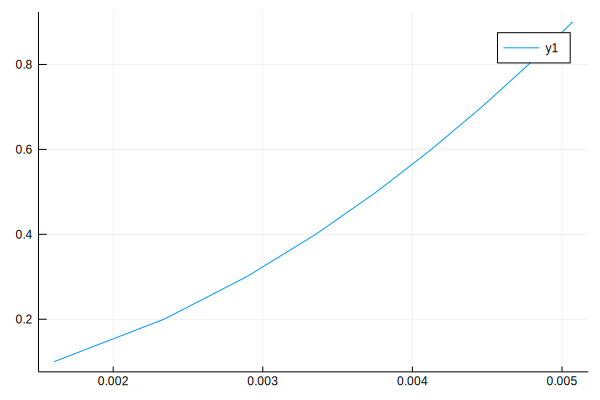

In [40]:
plot(lamValues, nsRange)